In [2]:
# ==============================================================================
# data_pipeline.ipynb
# Source data from dataset, preprocess, analyse, and experiment model with LIAR dataset.
#
# Written by: Honggyo Suh <honggyo.suh@student.unsw.edu.au>
# Date: 2023-11-02
# For TWEETTRUTH fake news detection system
# ==============================================================================

In [73]:
from datasets import load_dataset
import pandas as pd
import subprocess
import json
from joblib import dump
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from collections import Counter

from gensim import corpora, models

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from textblob import TextBlob

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import textstat

import spacy

from scipy.stats import uniform, loguniform, randint, reciprocal, expon, mannwhitneyu, ttest_ind, f_oneway

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, recall_score, precision_score, accuracy_score, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from torch.optim import Adam

In [74]:
# Access LIAR dataset via Huggingface, originally splitted into 3 sets, will combine and split again for our use
dataset = load_dataset('liar')
train_dataset = dataset['train']
test_dataset = dataset['test']
validation_dataset = dataset['validation']

In [75]:
print("train__________________________________________")
for index, data in enumerate(train_dataset):
    if index == 5:
        break
    print(data)
print("test__________________________________________")
for index, data in enumerate(test_dataset):
    if index == 5:
        break
    print(data)
print("validation__________________________________________")
for index, data in enumerate(validation_dataset):
    if index == 5:
        break
    print(data)

train__________________________________________
{'id': '2635.json', 'label': 0, 'statement': 'Says the Annies List political group supports third-trimester abortions on demand.', 'subject': 'abortion', 'speaker': 'dwayne-bohac', 'job_title': 'State representative', 'state_info': 'Texas', 'party_affiliation': 'republican', 'barely_true_counts': 0.0, 'false_counts': 1.0, 'half_true_counts': 0.0, 'mostly_true_counts': 0.0, 'pants_on_fire_counts': 0.0, 'context': 'a mailer'}
{'id': '10540.json', 'label': 1, 'statement': 'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.', 'subject': 'energy,history,job-accomplishments', 'speaker': 'scott-surovell', 'job_title': 'State delegate', 'state_info': 'Virginia', 'party_affiliation': 'democrat', 'barely_true_counts': 0.0, 'false_counts': 0.0, 'half_true_counts': 1.0, 'mostly_true_counts': 1.0, 'pants_on_fire_counts': 0.0, 'context': 'a floor speech.'}
{'id':

In [76]:
# Extract columns in data, frame into pandas dataframe for training/test
data = {"label": train_dataset['label'], "statement": train_dataset['statement'], "subject": train_dataset['subject']}
pd_train_dataset = pd.DataFrame(data)
data = {"label": test_dataset['label'], "statement": test_dataset['statement'], "subject": test_dataset['subject']}
pd_test_dataset = pd.DataFrame(data)
data = {"label": validation_dataset['label'], "statement": validation_dataset['statement'], "subject": validation_dataset['subject']}
pd_validation_dataset = pd.DataFrame(data)

In [5]:
print(pd_train_dataset.iloc[0])
print(pd_test_dataset.iloc[0])
print(pd_validation_dataset.iloc[0])

label                                                        0
statement    Says the Annies List political group supports ...
subject                                               abortion
Name: 0, dtype: object
label                                                        3
statement    Building a wall on the U.S.-Mexico border will...
subject                                            immigration
Name: 0, dtype: object
label                                                        4
statement    We have less Americans working now than in the...
subject                                           economy,jobs
Name: 0, dtype: object


In [13]:
# To process LIAR dataset with LIWC software for text analysis, saved results into the file considering the huge datasize.
# with open('train_analysis.txt', 'a') as f:
#     length = len(pd_train_dataset["statement"])
#     for index in range(length):
#         sentence = pd_train_dataset["statement"][index]
#         cmd_to_execute = [
#             "LIWC-22-cli",
#             "--mode", "wc",
#             "--input", "console",
#             "--console-text", sentence,
#             "--output", "console"
#         ]
#         try:
#             results = subprocess.check_output(cmd_to_execute, stderr=subprocess.DEVNULL).decode().strip().splitlines()
#             print(f"{index}/{length}")
#             f.write(results[7])
#             f.write('\n\n')
#         except Exception as e:
#             print(f"Error processing sentence: {sentence}. Error: {e}")

# with open('test_analysis.txt', 'a') as f:
#     length = len(pd_test_dataset["statement"])
#     for index in range(length):
#         sentence = pd_test_dataset["statement"][index]
#         cmd_to_execute = [
#             "LIWC-22-cli",
#             "--mode", "wc",
#             "--input", "console",
#             "--console-text", sentence,
#             "--output", "console"
#         ]
#         try:
#             results = subprocess.check_output(cmd_to_execute, stderr=subprocess.DEVNULL).decode().strip().splitlines()
#             print(f"{index}/{length}")
#             f.write(results[7])
#             f.write('\n\n')
#         except Exception as e:
#             print(f"Error processing sentence: {sentence}. Error: {e}")

# with open('validation_analysis.txt', 'a') as f:
#     length = len(pd_validation_dataset["statement"])
#     for index in range(length):
#         sentence = pd_validation_dataset["statement"][index]
#         cmd_to_execute = [
#             "LIWC-22-cli",
#             "--mode", "wc",
#             "--input", "console",
#             "--console-text", sentence,
#             "--output", "console"
#         ]
#         try:
#             results = subprocess.check_output(cmd_to_execute, stderr=subprocess.DEVNULL).decode().strip().splitlines()
#             print(f"{index}/{length}")
#             f.write(results[7])
#             f.write('\n\n')
#         except Exception as e:
#             print(f"Error processing sentence: {sentence}. Error: {e}")

In [77]:
# To prevent LIWC analysis result has missing columns and lead to system failure
def get_common_columns_from_analysis(file_list):
    common_columns = None
    for file in file_list:
        with open(file, "r") as f:
            lines = [line.rstrip() for line in f if line.rstrip()]
            list_of_dicts = [json.loads(line) for line in lines]
            if common_columns is None:
                common_columns = set(list_of_dicts[0].keys())
            else:
                common_columns &= set(list_of_dicts[0].keys())
    return common_columns

# Combine analysis result with origianl dataframe containing statement and label
def append_analysis_to_dataset(dataset, analysis_file, common_columns):
    with open(analysis_file, "r") as f:
        lines = [line.rstrip() for line in f if line.rstrip()]
        list_of_dicts = [json.loads(line) for line in lines]
        list_of_common_dicts = [{key: d[key] for key in common_columns} for d in list_of_dicts]
        analysis_df = pd.DataFrame(list_of_common_dicts)
        return pd.concat([dataset, analysis_df], axis=1)

common_columns = get_common_columns_from_analysis(["training_analysis.txt", "test_analysis.txt", "validation_analysis.txt"])
pd_train_dataset = append_analysis_to_dataset(pd_train_dataset, "training_analysis.txt", common_columns)
pd_test_dataset = append_analysis_to_dataset(pd_test_dataset, "test_analysis.txt", common_columns)
pd_validation_dataset = append_analysis_to_dataset(pd_validation_dataset, "validation_analysis.txt", common_columns)

# Map all 0-5 labels into 0, 1 binary classification
# mapping_function = lambda x: 0 if x in [0, 4, 5] else 1
# pd_train_dataset["label"] = pd_train_dataset["label"].map(mapping_function)
# pd_test_dataset["label"] = pd_test_dataset["label"].map(mapping_function)
# pd_validation_dataset["label"] = pd_validation_dataset["label"].map(mapping_function)

# Code for using 0, 1 labels only
pd_train_dataset = pd_train_dataset[pd_train_dataset["label"].isin([0, 1])]
pd_test_dataset = pd_test_dataset[pd_test_dataset["label"].isin([0, 1])]
pd_validation_dataset = pd_validation_dataset[pd_validation_dataset["label"].isin([0, 1])]

combined_df = pd.concat([pd_train_dataset, pd_test_dataset, pd_validation_dataset], axis=0, ignore_index=True)

In [56]:
print(combined_df.iloc[0])

label                                                        0
statement    Says the Annies List political group supports ...
subject                                               abortion
Affect                                                    9.09
tone_pos                                                   0.0
                                   ...                        
polite                                                     0.0
discrep                                                    0.0
AllPunc                                                  18.18
QMark                                                      0.0
mental                                                     0.0
Name: 0, Length: 122, dtype: object


In [78]:
# Count values of each label
label_counts = combined_df['label'].value_counts()

# Separate majority and minority classes
df_majority = combined_df[combined_df['label'] == 1]
df_minority = combined_df[combined_df['label'] == 0]

# Undersample the majority class
df_majority_undersampled = df_majority.sample(len(df_minority), random_state=42)  # setting a random_state for reproducibility

In [79]:
# Caculate sentiment analysis scores with Textblob library, add them to the dataframe
temp_majority_pol = [float(TextBlob(text).sentiment.polarity) for text in df_majority_undersampled['statement']]
temp_majority_sub = [float(TextBlob(text).sentiment.subjectivity) for text in df_majority_undersampled['statement']]
df_majority_undersampled['Polarity_txb'] = temp_majority_pol
df_majority_undersampled['Subjectivity_txb'] = temp_majority_sub

temp_minority_pol = [float(TextBlob(text).sentiment.polarity) for text in df_minority['statement']]
temp_minority_sub = [float(TextBlob(text).sentiment.subjectivity) for text in df_minority['statement']]
df_minority['Polarity_txb'] = temp_minority_pol
df_minority['Subjectivity_txb'] = temp_minority_sub

common_columns.add('Polarity_txb')
common_columns.add('Subjectivity_txb')

/var/folders/q6/nby1wjps6m3gtc3kp3rb92d80000gn/T/ipykernel_30604/97868387.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_minority['Polarity_txb'] = temp_minority_pol
/var/folders/q6/nby1wjps6m3gtc3kp3rb92d80000gn/T/ipykernel_30604/97868387.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_minority['Subjectivity_txb'] = temp_minority_sub


In [80]:
# Caculate sentiment analysis scores with Vader library, add them to the dataframe
analyzer = SentimentIntensityAnalyzer()

temp_majority_pos = [float(analyzer.polarity_scores(text)['pos']) for text in df_majority_undersampled['statement']]
temp_majority_neu = [float(analyzer.polarity_scores(text)['neu']) for text in df_majority_undersampled['statement']]
temp_majority_neg = [float(analyzer.polarity_scores(text)['neg']) for text in df_majority_undersampled['statement']]
temp_majority_comp = [float(analyzer.polarity_scores(text)['compound']) for text in df_majority_undersampled['statement']]
df_majority_undersampled['vader_pos'] = temp_majority_pos
df_majority_undersampled['vader_neu'] = temp_majority_neu
df_majority_undersampled['vader_neg'] = temp_majority_neg
df_majority_undersampled['vader_comp'] = temp_majority_comp

temp_minority_pos = [float(analyzer.polarity_scores(text)['pos']) for text in df_minority['statement']]
temp_minority_neu = [float(analyzer.polarity_scores(text)['neu']) for text in df_minority['statement']]
temp_minority_neg = [float(analyzer.polarity_scores(text)['neg']) for text in df_minority['statement']]
temp_minority_comp = [float(analyzer.polarity_scores(text)['compound']) for text in df_minority['statement']]
df_minority['vader_pos'] = temp_minority_pos
df_minority['vader_neu'] = temp_minority_neu
df_minority['vader_neg'] = temp_minority_neg
df_minority['vader_comp'] = temp_minority_comp

common_columns.add('vader_pos')
common_columns.add('vader_neu')
common_columns.add('vader_neg')
common_columns.add('vader_comp')

/var/folders/q6/nby1wjps6m3gtc3kp3rb92d80000gn/T/ipykernel_30604/1968023624.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_minority['vader_pos'] = temp_minority_pos
/var/folders/q6/nby1wjps6m3gtc3kp3rb92d80000gn/T/ipykernel_30604/1968023624.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_minority['vader_neu'] = temp_minority_neu
/var/folders/q6/nby1wjps6m3gtc3kp3rb92d80000gn/T/ipykernel_30604/1968023624.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [19]:
# To create average, T-test, One-way Anova, Manwhitneyu test results and save into file for analysis
# columns = []
# with open('columns_to_scale', 'r') as f:
#     columns = f.readlines()

# with open('LIWC_average_fake', 'w') as f:
#     for column in columns:
#         column = column.rstrip()
        
#         real = [value for value in df_majority_undersampled[column]]
#         fake = [value for value in df_minority[column]]

#         f.write(f"{column}:{sum(fake) / len(fake)}")
#         f.write("\n")
        
        # stat, p = ttest_ind(real, fake)
        # stat, p = f_oneway(real, fake)
        # stat, p = mannwhitneyu(real, fake)

        # alpha = 0.05

        # if p < alpha:
        #     f.write(f"{column}, statistics: {stat:.3f}, p-value: {p:.3f}")
        #     f.write("\n")

In [20]:
# Code for using effective columns found from tests only
# ttest_columns = set()
# anova_columns = set()
# mannwhitneyu_columns = set()

# with open('ttest.txt', 'r') as f:
#     ttest_lines = f.readlines()
#     ttest_columns = set(line.split(",")[0] for line in ttest_lines)
# with open('anova.txt', 'r') as f:
#     anova_lines = f.readlines()
#     anova_columns = set(line.split(",")[0] for line in anova_lines)
# with open('manwhitneyu.txt', 'r') as f:
#     manwhitneyu_lines = f.readlines()
#     manwhitneyu_columns = set(line.split(",")[0] for line in manwhitneyu_lines)

# common_columns_from_analysis = anova_columns & manwhitneyu_columns

# with open('temp.txt', 'w') as f:
#     for column in common_columns_from_analysis:
#         f.write(column)
#         f.write("\n")

In [81]:
# Combine and split data into training/test
balanced_training_first, balanced_test_first = train_test_split(df_majority_undersampled, test_size=0.1, random_state=42)  # Setting a random state for reproducibility
balanced_training_second, balanced_test_second = train_test_split(df_minority, test_size=0.1, random_state=42)  # Setting a random state for reproducibility

balanced_training = pd.concat([balanced_training_first, balanced_training_second], axis=0)
balanced_test = pd.concat([balanced_test_first, balanced_test_second], axis=0)

In [82]:
# Split each dataset with their label for analysis
balanced_training_true = balanced_training[balanced_training['label'] == 1]
balanced_training_fake = balanced_training[balanced_training['label'] == 0]
balanced_test_true = balanced_test[balanced_test['label'] == 1]
balanced_test_fake = balanced_test[balanced_test['label'] == 0]

In [102]:
print(balanced_test_fake.iloc[10].statement)

Presidents Hoover, Truman and Eisenhower collectively ordered the deportation of at least 15 million illegal aliens.


In [83]:
# Tokenise/clean statements into tokens, count the common words each in fake and true dataset
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Common words will only be extracted from training dataset to prevent target exposure
balanced_training_true['clean_text'] = balanced_training_true['statement'].str.lower().str.replace(r'[^\w\s]+', ' ', regex=True)
balanced_training_true['tokens'] = balanced_training_true['clean_text'].apply(word_tokenize)
balanced_training_true['filtered_tokens'] = balanced_training_true['tokens'].apply(lambda tokens: [w for w in tokens if not w in stop_words])
all_words_true = [word for tokens in balanced_training_true['filtered_tokens'] for word in tokens]
word_freq_true = Counter(all_words_true)

balanced_training_fake['clean_text'] = balanced_training_fake['statement'].str.lower().str.replace(r'[^\w\s]+', ' ', regex=True)
balanced_training_fake['tokens'] = balanced_training_fake['clean_text'].apply(word_tokenize)
balanced_training_fake['filtered_tokens'] = balanced_training_fake['tokens'].apply(lambda tokens: [w for w in tokens if not w in stop_words])
all_words_fake = [word for tokens in balanced_training_fake['filtered_tokens'] for word in tokens]
word_freq_fake = Counter(all_words_fake)

balanced_test_true['clean_text'] = balanced_test_true['statement'].str.lower().str.replace(r'[^\w\s]+', ' ', regex=True)
balanced_test_true['tokens'] = balanced_test_true['clean_text'].apply(word_tokenize)
balanced_test_true['filtered_tokens'] = balanced_test_true['tokens'].apply(lambda tokens: [w for w in tokens if not w in stop_words])

balanced_test_fake['clean_text'] = balanced_test_fake['statement'].str.lower().str.replace(r'[^\w\s]+', ' ', regex=True)
balanced_test_fake['tokens'] = balanced_test_fake['clean_text'].apply(word_tokenize)
balanced_test_fake['filtered_tokens'] = balanced_test_fake['tokens'].apply(lambda tokens: [w for w in tokens if not w in stop_words])

[nltk_data] Downloading package punkt to /Users/seohong-
[nltk_data]     gyo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/seohong-
[nltk_data]     gyo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/q6/nby1wjps6m3gtc3kp3rb92d80000gn/T/ipykernel_30604/665222330.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balanced_training_true['clean_text'] = balanced_training_true['statement'].str.lower().str.replace(r'[^\w\s]+', ' ', regex=True)
/var/folders/q6/nby1wjps6m3gtc3kp3rb92d80000gn/T/ipykernel_30604/665222330.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [84]:
# Check word frequencis, make a list of common words
frequencies_true = list(word_freq_true.values())
true_word_sum = sum(frequencies_true)
mean_freq_true = np.mean(frequencies_true)
std_freq_true = np.std(frequencies_true)
threshold_true = mean_freq_true + std_freq_true
percentile_95_true = np.percentile(frequencies_true, 95)
common_words_true = set(word for word, freq in word_freq_true.items() if freq > threshold_true)

frequencies_fake = list(word_freq_fake.values())
fake_word_sum = sum(frequencies_fake)
mean_freq_fake = np.mean(frequencies_fake)
std_freq_fake = np.std(frequencies_fake)
threshold_fake = mean_freq_fake + std_freq_fake
percentile_95_fake = np.percentile(frequencies_fake, 95)
common_words_fake = set(word for word, freq in word_freq_fake.items() if freq > threshold_fake)

only_common_in_fake = common_words_true - common_words_fake
only_common_in_true = common_words_fake - common_words_true

only_common_in_fake_with_prob = [(word, freq / fake_word_sum) for word, freq in word_freq_fake.items() if freq > threshold_fake]
only_common_in_true_with_prob = [(word, freq / true_word_sum) for word, freq in word_freq_true.items() if freq > threshold_true]

In [25]:
# # Code for using topic analysis
# dictionary = corpora.Dictionary([df_minority['filtered_tokens'].iloc[0]])
# # Create a corpus: list of bag-of-words vectors for each document
# corpus = [dictionary.doc2bow(token) for token in [df_minority['filtered_tokens'].iloc[0]]]

# num_topics = 1

# lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# topics = lda_model.print_topics(num_words=5)
# for topic in sorted(topics, reversed=True):
#     print(topic)
# print(df_minority['statement'].iloc[0])

In [26]:
# Code for using Named Entity Recognition
# nlp_model = nlp = spacy.load("en_core_web_sm")
# elements = []

# # for text in df_minority['statement']:
# document = nlp_model("".join(df_minority['statement']))

# for entity in document.ents:
#     elements.append(entity)

# dict_counter = Counter(elements)
# print(set(dict_counter.values()))
# sorted_counter_by_value = {k: v for k, v in sorted(dict_counter.items(), key=lambda item: item[1], reverse=True)}

In [85]:
# Combine splitted dataset into training/test again
balanced_training = pd.concat([balanced_training_true, balanced_training_fake], axis=0, ignore_index=True)
balanced_test = pd.concat([balanced_test_fake, balanced_test_true], axis=0, ignore_index=True)

In [86]:
# Caculate sentiment analysis scores with Textstat library, add them to the dataframe
common_columns.update(['flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog', 'smog_index', 'ari', 'coleman_liau_index', 'linsear_write', 'dale_chall'])

flesch_reading_ease_tr = [textstat.flesch_reading_ease(text) for text in balanced_training['statement']]
flesch_kincaid_grade_tr = [textstat.flesch_kincaid_grade(text) for text in balanced_training['statement']]
gunning_fog_tr = [textstat.gunning_fog(text) for text in balanced_training['statement']]
smog_index_tr = [textstat.smog_index(text) for text in balanced_training['statement']]
ari_tr = [textstat.automated_readability_index(text) for text in balanced_training['statement']]
coleman_liau_index_tr = [textstat.coleman_liau_index(text) for text in balanced_training['statement']]
linsear_write_tr = [textstat.linsear_write_formula(text) for text in balanced_training['statement']]
dale_chall_tr = [textstat.dale_chall_readability_score(text) for text in balanced_training['statement']]

balanced_training['flesch_reading_ease'] = flesch_reading_ease_tr
balanced_training['flesch_kincaid_grade'] = flesch_kincaid_grade_tr
balanced_training['gunning_fog'] = gunning_fog_tr
balanced_training['smog_index'] = smog_index_tr
balanced_training['ari'] = ari_tr
balanced_training['coleman_liau_index'] = coleman_liau_index_tr
balanced_training['linsear_write'] = linsear_write_tr
balanced_training['dale_chall'] = dale_chall_tr


flesch_reading_ease_test = [textstat.flesch_reading_ease(text) for text in balanced_test['statement']]
flesch_kincaid_grade_test = [textstat.flesch_kincaid_grade(text) for text in balanced_test['statement']]
gunning_fog_test = [textstat.gunning_fog(text) for text in balanced_test['statement']]
smog_index_test = [textstat.smog_index(text) for text in balanced_test['statement']]
ari_test = [textstat.automated_readability_index(text) for text in balanced_test['statement']]
coleman_liau_index_test = [textstat.coleman_liau_index(text) for text in balanced_test['statement']]
linsear_write_test = [textstat.linsear_write_formula(text) for text in balanced_test['statement']]
dale_chall_test = [textstat.dale_chall_readability_score(text) for text in balanced_test['statement']]

balanced_test['flesch_reading_ease'] = flesch_reading_ease_test
balanced_test['flesch_kincaid_grade'] = flesch_kincaid_grade_test
balanced_test['gunning_fog'] = gunning_fog_test
balanced_test['smog_index'] = smog_index_test
balanced_test['ari'] = ari_test
balanced_test['coleman_liau_index'] = coleman_liau_index_test
balanced_test['linsear_write'] = linsear_write_test
balanced_test['dale_chall'] = dale_chall_test

In [87]:
temp = []
with open("common_in_fake.txt") as f:
    temp = [(line.rstrip().split()[0], float(line.rstrip().split()[1])) for line in f.readlines()]
only_common_in_fake_with_prob = temp

temp = []
with open("common_in_true.txt") as f:
    temp = [(line.rstrip().split()[0], float(line.rstrip().split()[1])) for line in f.readlines()]
only_common_in_true_with_prob = temp

In [ ]:
# Add common words score/existance to the dataframe
for column in only_common_in_fake_with_prob:
    balanced_training[column[0]] = [column[1] if column[0] in text else 0 for text in balanced_training['filtered_tokens']]
    common_columns.add(column[0])
balanced_training['common_words_score_fake'] = [sum([tuple[1] for tuple in only_common_in_fake_with_prob if tuple[0] in text]) for text in balanced_training['filtered_tokens']]
common_columns.add('common_words_score_fake')

for column in only_common_in_true_with_prob:
    balanced_training[column[0]] = [column[1] if column[0] in text else 0 for text in balanced_training['filtered_tokens']]
    common_columns.add(column[0])
balanced_training['common_words_score_true'] = [sum([tuple[1] for tuple in only_common_in_true_with_prob if tuple[0] in text]) for text in balanced_training['filtered_tokens']]
common_columns.add('common_words_score_true')

for column in only_common_in_fake_with_prob:
    balanced_test[column[0]] = [column[1] if column[0] in text else 0 for text in balanced_test['filtered_tokens']]
balanced_test['common_words_score_fake'] = [sum([tuple[1] for tuple in only_common_in_fake_with_prob if tuple[0] in text]) for text in balanced_test['filtered_tokens']]

for column in only_common_in_true_with_prob:
    balanced_test[column[0]] = [column[1] if column[0] in text else 0 for text in balanced_test['filtered_tokens']] 
balanced_test['common_words_score_true'] = [sum([tuple[1] for tuple in only_common_in_true_with_prob if tuple[0] in text]) for text in balanced_test['filtered_tokens']]

In [89]:
# List of numerical columns to scale
columns_to_scale = [column_name for column_name in common_columns if column_name not in ['statement', 'subject', 'label']]

# Initialize the standard scaler
scaler = StandardScaler()

# Fit the scaler on the data
scaler.fit(balanced_training[columns_to_scale])
dump(scaler, 'standard_scaler.pkl')

# Transform the data
balanced_training[columns_to_scale] = scaler.transform(balanced_training[columns_to_scale])
balanced_test[columns_to_scale] = scaler.transform(balanced_test[columns_to_scale])

In [90]:
# To check the list/order of columns for scaling
with open('columns_to_scale', 'w') as f:
    for column in columns_to_scale:
        f.write(column)
        f.write('\n')

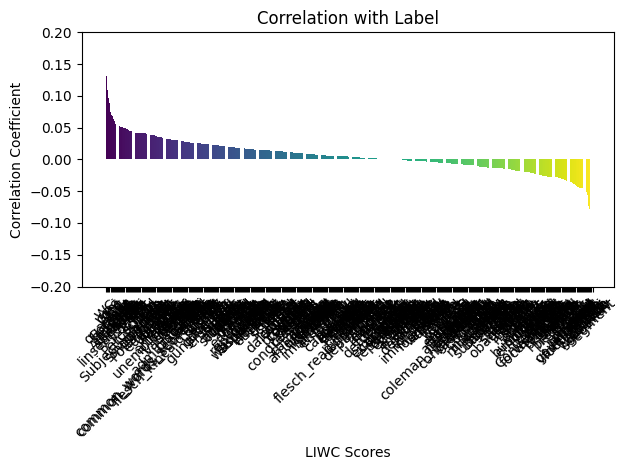

In [91]:
# Calculate correlation coefficient for data analysis
correlation_dataframe = balanced_training.drop(columns=["statement", "subject", "tokens", "clean_text", "filtered_tokens"])
correlation_matrix = correlation_dataframe.corr()
label_correlations = correlation_matrix["label"]

# Use the common_columns for plotting, but exclude the 'label' column
liwc_scores = [col for col in common_columns if col != 'label']
correlations = label_correlations[liwc_scores]
correlations = correlations.sort_values(ascending=False)
high_corr = []

# Code to use columns with relatively higher correlations 
with open("correlation.txt", "w") as f:
    for column, coeff in correlations.items():
        f.write(f"Correlation between {column} and label: {coeff:.4f}\n")
        if abs(coeff) > 0.03:
            high_corr.append(column)

# Using a colormap to generate a varying set of colors based on the number of columns
colors = plt.cm.viridis(np.linspace(0, 1, len(correlations)))

plt.bar(correlations.index, correlations.values, color=colors)
plt.title('Correlation with Label')
plt.ylabel('Correlation Coefficient')
plt.xlabel('LIWC Scores')
plt.ylim(-0.2, 0.2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [92]:
# Make a list of features/target for prediction/test
features = [col for col in common_columns if col not in ['label', 'statement', 'subject', 'Segment', 'filler', 'Emoji']]

training_prediction_target = balanced_training.label
training_prediction_target.astype(int)
training_prediction_features = balanced_training[features]
test_prediction_target = balanced_test.label
test_prediction_target.astype(int)
test_prediction_features = balanced_test[features]

In [93]:
# To check the list/order of columns for prediction
with open("columns_to_predict", "w") as f:
    for column in features:
        f.write(column)
        f.write("\n")

In [94]:
# Calculate/print evaluation scores
def calc_score(target, prediction):
    accuracy = accuracy_score(target, prediction)
    f1 = f1_score(target, prediction)
    cm = confusion_matrix(target, prediction)
    TN, FP, FN, TP = cm.ravel()

    print("Accuracy:", accuracy)
    print("F1:", f1)
    print("TP:", TP)
    print("TN:", TN)
    print("FP:", FP)
    print("FN:", FN)

    return f1

In [25]:
def decision_tree(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    calc_score(val_y, preds_val)
    print("_________________________")

In [ ]:
for max_leaf_node in [60]:
    decision_tree(max_leaf_node, training_prediction_features, test_prediction_features, training_prediction_target, test_prediction_target)

In [133]:
def random_forest(estimators, train_X, val_X, train_y, val_y):
    model = RandomForestClassifier(n_estimators=estimators, random_state=1)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    calc_score(val_y, preds_val)
    print("_________________________")

In [ ]:
for estimators in [5, 50, 100, 150, 200]:
    random_forest(estimators, training_prediction_features, test_prediction_features, training_prediction_target, test_prediction_target)

In [112]:
param_dist = {
    'C': loguniform(1e-5, 100),  # Log-uniform distribution for C
    'penalty': ['l1'],  # Different types of penalties
    'solver': ['saga'],  # 'saga' solver works with l1 and elasticnet penalties
}

In [ ]:
best_score = 0

while best_score < 0.65:
    # Create the logistic regression model
    model = LogisticRegression(random_state=5, max_iter=10000)  # Increased max_iter for convergence

    # Instantiate the RandomizedSearchCV object
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=5)

    # Fit the RandomizedSearchCV object to the training data
    random_search.fit(training_prediction_features, training_prediction_target)

    # Predict on validation set using the best found parameters
    preds_val = random_search.predict(test_prediction_features)
    best_score = calc_score(test_prediction_target, preds_val)

    with open("experiment_result_Log.txt", "a") as f:
        f.write(str(random_search.best_params_))
        f.write("\n")
        f.write(str(random_search.best_score_))
        f.write("\n")
        f.write(str(best_score))
        f.write("\n\n")
        
os.system( "say beep" )
os.system( "say beep" )
os.system( "say beep" )
os.system( "say beep" )
os.system( "say beep" )

In [95]:
def logistic_regression(iteration, train_X, val_X, train_y, val_y):
    model = LogisticRegression(max_iter=iteration, random_state=2)
    model.fit(train_X, train_y)
    dump(model, "logistic_regression.pkl")
    preds_val = model.predict(val_X)
    calc_score(val_y, preds_val)
    print("_________________________")

In [97]:
for iteration in [190]:
    logistic_regression(iteration, training_prediction_features, test_prediction_features, training_prediction_target, test_prediction_target)

Accuracy: 0.6408730158730159
F1: 0.6471734892787525
TP: 166
TN: 157
FP: 95
FN: 86
_________________________


In [135]:
# Define the parameter grid
param_dist = {
    'n_estimators': randint(100, 1000),  # Number of trees in the forest
    'max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'max_depth': randint(10, 100),  # Maximum number of levels in each decision tree
    'min_samples_split': randint(2, 10),  # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 10),  # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

In [ ]:
best_score = 0

while best_score < 0.65:
    model = ExtraTreesClassifier(random_state=5)

    # Instantiate the RandomizedSearchCV object
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=5)

    # Fit the RandomizedSearchCV object to the training data
    random_search.fit(training_prediction_features, training_prediction_target)

    # Predict on validation set using the best found parameters
    preds_val = random_search.predict(test_prediction_features)
    best_score = calc_score(test_prediction_target, preds_val)

    with open("experiment_result_SVM.txt", "a") as f:
        f.write(str(random_search.best_params_))
        f.write("\n")
        f.write(str(random_search.best_score_))
        f.write("\n")
        f.write(str(best_score))
        f.write("\n\n")
os.system( "say beep" )
os.system( "say beep" )
os.system( "say beep" )
os.system( "say beep" )
os.system( "say beep" )

In [33]:
# Define the parameter grid
param_dist = {
    'n_neighbors': randint(1, 30),  # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
    'p': [1, 2]  # Power parameter for the Minkowski metric
}

In [ ]:
best_score = 0

while best_score < 0.65:
    model = KNeighborsClassifier()

    # Instantiate the RandomizedSearchCV object
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=5)

    # Fit the RandomizedSearchCV object to the training data
    random_search.fit(training_prediction_features, training_prediction_target)

    # Predict on validation set using the best found parameters
    preds_val = random_search.predict(test_prediction_features)
    best_score = calc_score(test_prediction_target, preds_val)

    with open("experiment_result_SVM.txt", "a") as f:
        f.write(str(random_search.best_params_))
        f.write("\n")
        f.write(str(random_search.best_score_))
        f.write("\n")
        f.write(str(best_score))
        f.write("\n\n")
os.system( "say beep" )
os.system( "say beep" )
os.system( "say beep" )
os.system( "say beep" )
os.system( "say beep" )

In [35]:
# Define the parameter grid
param_dist = {
    'var_smoothing': loguniform(1e-9, 1e0)  # Log-uniform distribution for var_smoothing
}

In [ ]:
best_score = 0

while best_score < 0.65:
    model = GaussianNB()

    # Instantiate the RandomizedSearchCV object
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=5)

    # Fit the RandomizedSearchCV object to the training data
    random_search.fit(training_prediction_features, training_prediction_target)

    # Predict on validation set using the best found parameters
    preds_val = random_search.predict(test_prediction_features)
    best_score = calc_score(test_prediction_target, preds_val)

    with open("experiment_result_SVM.txt", "a") as f:
        f.write(str(random_search.best_params_))
        f.write("\n")
        f.write(str(random_search.best_score_))
        f.write("\n")
        f.write(str(best_score))
        f.write("\n\n")
os.system( "say beep" )
os.system( "say beep" )
os.system( "say beep" )
os.system( "say beep" )
os.system( "say beep" )

In [37]:
param_dist = {
    'C': reciprocal(1e-6, 1e+6),  # Reciprocal distribution for C
    'gamma': expon(scale=1.0),  # Exponential distribution for gamma
    'kernel': ['rbf', 'linear', 'sigmoid', 'poly'],  # Include 'poly' for polynomial kernel
    'degree': randint(2, 5)  # Specify a range for 'degree' if using 'poly' kernel
}

In [ ]:
best_score = 0

while best_score < 0.65:
    model = SVC(random_state=5)

    # Instantiate the RandomizedSearchCV object
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=3, cv=3, verbose=1, n_jobs=-1, random_state=5)

    # Fit the RandomizedSearchCV object to the training data
    random_search.fit(training_prediction_features, training_prediction_target)

    # Predict on validation set using the best found parameters
    preds_val = random_search.predict(test_prediction_features)
    best_score = calc_score(test_prediction_target, preds_val)

    with open("experiment_result_SVM.txt", "a") as f:
        f.write(str(random_search.best_params_))
        f.write("\n")
        f.write(str(random_search.best_score_))
        f.write("\n")
        f.write(str(best_score))
        f.write("\n\n")
os.system( "say beep" )
os.system( "say beep" )
os.system( "say beep" )
os.system( "say beep" )
os.system( "say beep" )

In [137]:
def SVM(train_X, val_X, train_y, val_y, gamma_val, degree_val):
    model = SVC(kernel='poly', gamma=gamma_val, degree=degree_val, random_state=3, probability=True)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    calc_score(val_y, preds_val)
    print("_________________________")

In [ ]:
for degree_val in [3, 4, 5]:
    print(SVM(training_prediction_features, test_prediction_features, training_prediction_target, test_prediction_target, 'scale', degree_val))

In [ ]:
def gradient_boost(estimators, train_X, val_X, train_y, val_y, learning_rate, max_depth, subsample, max_features):
    model = GradientBoostingClassifier(
        n_estimators=estimators, 
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        max_features=max_features,
        random_state=4
    )    
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    calc_score(val_y, preds_val)
    print("_________________________")

In [ ]:
for estimators in [5, 50]:
    gradient_boost(estimators, training_prediction_features, test_prediction_features, training_prediction_target, test_prediction_target, 1.0, 5, 1.0, None)

In [120]:
param_dist = {
    'learning_rate': uniform(0.01, 0.99),  # Uniform distribution from 0.01 to 0.61 (0.01 + 0.6)
    'n_estimators': randint(5, 2000),    # Discrete uniform distribution from 50 to 1000
    'max_depth': randint(3, 12),          # Discrete uniform distribution from 3 to 10
}

In [ ]:
best_score = 0

while best_score < 0.65:
    # Create the XGBoost model
    model = XGBClassifier(random_state=5)

    # Instantiate the RandomizedSearchCV object
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=6)

    # Fit the RandomizedSearchCV object to the training data
    random_search.fit(training_prediction_features, training_prediction_target)

    # Predict on validation set using the best found parameters
    preds_val = random_search.predict(test_prediction_features)
    best_score = calc_score(test_prediction_target, preds_val)

    with open("experiment_result.txt", "a") as f:
        f.write(str(random_search.best_params_))
        f.write("\n")
        f.write(str(random_search.best_score_))
        f.write("\n")
        f.write(str(best_score))
        f.write("\n\n")
os.system( "say beep" )
os.system( "say beep" )
os.system( "say beep" )
os.system( "say beep" )
os.system( "say beep" )

In [28]:
def xg_boost(n_estimators, train_X, val_X, train_y, val_y):
    model = XGBClassifier(learning_rate = 0.01, n_estimators = n_estimators, max_depth = 5, random_state=5)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    calc_score(val_y, preds_val)
    print("_________________________")

In [ ]:
for estimator in [100, 125, 150, 175, 200]:
    print(xg_boost(estimator, training_prediction_features, test_prediction_features, training_prediction_target, test_prediction_target))

In [ ]:
# Assuming X_train, y_train, X_test, y_test are your data in NumPy arrays
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(training_prediction_features.values, dtype=torch.float32)
y_train_tensor = torch.tensor(training_prediction_target.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(test_prediction_features.values, dtype=torch.float32)
y_test_tensor = torch.tensor(test_prediction_target.values, dtype=torch.float32).view(-1, 1)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the model
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Linear(512, 256)  # First hidden layer
        self.layer2 = nn.Linear(256, 128)   # Second hidden layer
        self.layer3 = nn.Linear(128, 64)   # Adding a third hidden layer
        self.layer4 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)  # Output layer
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))  # Activation for the third hidden layer
        x = self.relu(self.layer4(x))
        x = torch.sigmoid(self.output_layer(x))
        return x

# Instantiate the model
model = BinaryClassifier()

# Define the loss function and optimizer
loss_function = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.0001)

# Training loop
for epoch in range(15):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Forward pass
        outputs = model(data)
        loss = loss_function(outputs, target.view(-1, 1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Evaluate the model
model.eval()  # Set the model to evaluation mode
all_targets = []
all_predictions = []

with torch.no_grad():
    correct = 0
    total = 0
    for data, target in test_loader:
        outputs = model(data)
        predicted = (outputs.data > 0.5).float()  # Threshold the outputs to get binary class predictions
        # Add to the total number of examples
        total += target.size(0)
        # Add to the correct count if the prediction matches the target
        correct += (predicted.view(-1) == target.view(-1)).sum().item()
        # Extend the list of targets and predictions for F1 score calculation
        all_targets.extend(target.view(-1).numpy())
        all_predictions.extend(predicted.view(-1).numpy())


accuracy = correct / total
print(f'Accuracy of the model on the test data: {accuracy:.2f}%')
f1 = f1_score(all_targets, all_predictions)
print(f'F1 Score of the model on the test data: {f1:.2f}')